In [3]:
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import shap
#import shap.explainers.deep.deep_tf
import lime
from lime.lime_image import LimeImageExplainer
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import Sequential
import ssl
from skimage.segmentation import mark_boundaries

import argparse
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image


from modules.model import A2IModel
# from modules_label_ensemble.model import Expert as A2IModel
from modules.lr_scheduler import CustomOneCycleSchedule, LearningRateLogger
import functions
from cfg import configs
# from cfg_label_ensemble import configs


data_path = '/home/gyuseonglee/workspace/dataset/chexpert-resized'
# data_path = YOUR_DATA_DIR
full_model_weight_path = '/home/gyuseonglee/workspace/maai-cxr/src/kslee001/quantization/weights/ensemble/densenet121_7000_test.h5'
# full_model_weight_path = '/home/gyuseonglee/workspace/maai-cxr/src/kslee001/quantization/weights/label_ensemble/atel/atel_densenet121_317_test.h5'
# quant_model_wieght_path = '/home/gyuseonglee/workspace/maai-cxr/src/kslee001/ensemble/densenet121_1005.tflite'
# path = YOUR_MODEL_PATH

configs.model.backbone = 'densenet'
configs.wandb.use_wandb = False
configs.general.batch_size = 1

# ===== CHECK YOUR DATA DIRECTORY ===== 
configs.dataset.data_dir = data_path
# ===== CHECK YOUR DATA DIRECTORY ===== 

configs.dataset.cutoff = 1000


train_dataset, valid_dataset, test_dataset = functions.load_datasets(configs) 
configs.general.steps_per_epoch = train_dataset.steps_per_epoch


"""
LOAD FULL MODEL (TF)
"""
model = A2IModel(configs=configs)
model.initialize()

# ===== CHECK YOUR FULL MODEL WEIGHT DIRECTORY ===== 
model.load_weights(full_model_weight_path)
# ===== CHECK YOUR FULL MODEL WEIGHT DIRECTORY ===== 


criterion = tf.keras.losses.CategoricalCrossentropy(
    # from_logits=True,
    from_logits=False, 
    label_smoothing=configs.model.label_smoothing,
    reduction=tf.keras.losses.Reduction.SUM if configs.general.distributed else 'auto'
)
model.compile(loss=criterion)
model.initialize()
print("MODEL loaded")

MODEL loaded


In [4]:
import shap
#import shap.explainers.deep.deep_tf
import lime
from lime import lime_image
from lime.lime_image import LimeImageExplainer

In [5]:
batch = next(iter(valid_dataset))
image = batch[0][0][:, :, 0]
image.shape

TensorShape([320, 320])

In [6]:
def classify(image):
    return model(image)[0] # atel prediction

In [7]:
classify(batch[0]).numpy()[0]

array([0.64519686, 0.35480314], dtype=float32)

In [9]:
# get positive sample
a = 0
for idx, batch in enumerate(valid_dataset):
    if (batch[1][0][0] == 1.0):
        if classify(batch[0]).numpy()[0][1] > 0.5:
            break
        
# image, label = next(iter(valid_dataset))
image, label = batch
image_numpy = tf.concat([image, image, image], axis=-1)
image_numpy = image.numpy().squeeze()
label = label[:, 0].numpy()
print("tensor shape : ", image.shape)
print("numpy  shape ",image_numpy.shape)
print("label shape  ", label.shape)

tensor shape :  (1, 320, 320, 1)
numpy  shape  (320, 320)
label shape   (1,)


In [10]:
out = classify(image)
out

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.4590462 , 0.54095376]], dtype=float32)>

In [11]:
label

array([1.], dtype=float32)

In [12]:
explainer = lime_image.LimeImageExplainer()
explainer_l = explainer.explain_instance(
    image=image_numpy,
    labels=label,
    classifier_fn=classify, 
    hide_color=0, 
    top_labels=2, 
    num_samples=1
)


  0%|          | 0/1 [00:00<?, ?it/s]

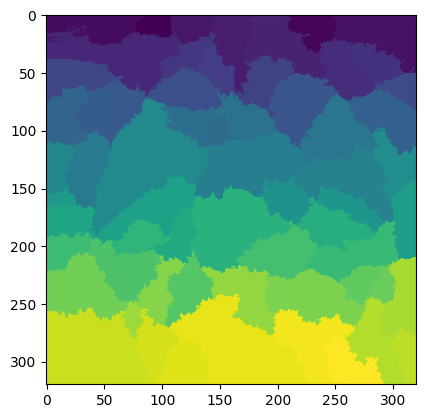

In [13]:
plt.imshow(explainer_l.segments)

In [ ]:
temp, mask = explainer_l.get_image_and_mask(1, positive_only=False, num_features=40, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = False, hide_background = False):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    #plt.savefig('lime_pred.png')
    plt.axis('off')
    plt.show()

In [ ]:
generate_prediction_sample(explainer_l, explainer_l.top_labels[1], show_positive = True, hide_background = False)    

In [ ]:
plt.imshow(image_numpy)

In [ ]:
temp, mask = explainer_l.get_image_and_mask(
    240, positive_only=True, num_features=2, hide_rest=True)


In [ ]:
model(image)

In [ ]:
explainer_l = explainer.explain_instance(images[0], new_model.predict, hide_color=0, top_labels=2, num_samples=1000)


### shap

In [ ]:
# get positive sample
a = 0
for idx, batch in enumerate(valid_dataset):
    if (batch[1][0][0] == 1.0):
        if classify(batch[0]).numpy()[0][1] > 0.5:
            break
        
# image, label = next(iter(valid_dataset))
image, label = batch
image_numpy = tf.concat([image, image, image], axis=-1)
image_numpy = image.numpy().squeeze()
label = label[:, 0].numpy()
print("tensor shape : ", image.shape)
print("numpy  shape ",image_numpy.shape)

In [ ]:
image

In [ ]:
valid_images = []
for idx, batch in enumerate(valid_dataset):
#     x = tf.squeeze(batch[0], axis=0)
    valid_images.append(tf.reshape(tf.concat([x,x,x], axis=-1), [320, 320, 3]))
valid_images = np.stack(valid_images)
valid_images.shape

In [ ]:
masker0 = shap.maskers.Image("inpaint_telea", image.shape)    

In [ ]:
# background = valid_images[np.random.choice(valid_images[0].shape, 50, replace=False)]


In [ ]:
model(image)[0].numpy()[0][1]

In [ ]:
image.shape

In [ ]:
valid_images.shape

In [ ]:
def model_wrapper(x):
    out = model(x)
    return out[0]
    

In [ ]:
explainer = shap.DeepExplainer(model_wrapper, valid_images)
# shap_values = explainer.shap_values(X_test)

In [ ]:
#%%
# load package
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import shap
#import shap.explainers.deep.deep_tf
import lime
from lime import lime_image
from lime.lime_image import LimeImageExplainer
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import keras.backend as K
from keras.models import Sequential
import ssl
from skimage.segmentation import mark_boundaries

import argparse
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
from models.ensemble.modules.model import A2IModel
from models.ensemble.modules.lr_scheduler import CustomOneCycleSchedule, LearningRateLogger
import models.ensemble.functions as functions
from models.ensemble.cfg import configs

In [ ]:
import deeplift
from deeplift.layers import NonlinearMxtsMode
from deeplift.conversion import kerasapi_conversion as kc
from deeplift.util import compile_func

In [ ]:
TARGET_COLUMNS = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion']
NUM_CLASSES = len(TARGET_COLUMNS)
AUTOTUNE = tf.data.AUTOTUNE
IMAGE_SIZE = [320, 320]
BATCH_SIZE = 1
MODEL_DIR = '/home/n0/a2i006/xai/models/ensemble/test/densenet121_10000_test.h5'
MODEL_DIR_Q = '/home/n0/a2i006/xai/models/baseline_quant_model.tflite'

DATASET_DIR = '/home/n0/a2i006/xai/dataset'
DATASET_NAME = 'CheXpert-v1.0-small'
TEST_SIZE = 0.1 # enough

In [ ]:
# return : dataframe with columns [Path, label_1, label_2, ... label_n]
def csv_to_df(dataset_dir, dataset_name):
    # TODO : load data into pandas dataframe
    data = pd.read_csv(f"{dataset_dir}/valid.csv").fillna(0.0)

    # TODO : fix image path:
    # ex. CheXpert-v1.0/patient0000...
    # ex.       > /mnt/e/dataset/chexpert/CheXpert-v1.0/patient0000...
    data['Path'] = data['Path'].str.replace(dataset_name, dataset_dir, regex=False)

    # TODO : fill null values
    for col_idx in range(5, len(data.columns)):
        data[data.columns[col_idx]] = data[data.columns[col_idx]].astype(str)
        data[data.columns[col_idx]] = data[data.columns[col_idx]].str.replace("-1.0", "0.0").astype(float).fillna(0.0)

    # TODO : column reduction
    target_columns = ['Path'] + TARGET_COLUMNS
    dataframe = data[target_columns].reset_index(drop=True)

    return dataframe

In [ ]:
def process_path_validation(image_path, label):
    # Read the image from the path
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1) #3
    image = tf.image.resize(image, [320, 320])
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

In [ ]:
def transform(dataset_dir):
    # make train_images
    train_images = []
    for i in range(64541, 64741):
        img_path = f"{dataset_dir}/valid/patient{i}/study1/view1_frontal.jpg"
        img = image.load_img(img_path, target_size=(320, 320))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = x / 255.0
        train_images.append(x)

    # Convert the list to a numpy array
    # (number_of_images, height, width, channels). (48, 320, 320, 3).
    train_images = np.concatenate(train_images, axis=0) 
    #print(train_images.shape)
    
    return train_images

In [ ]:
def get_model_predictions(data):
    model_prediction = model.predict(data)
    print(f"The predicted class is : {decode_predictions(model_prediction, top=1)[0][0][1]}")
    return decode_predictions(model_prediction, top=1)[0][0][1]

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = False, hide_background = False):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''
    image, mask = exp.get_image_and_mask(exp_class, 
                                         positive_only=show_positive, 
                                         num_features=6, 
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    plt.imshow(mark_boundaries(image, mask))
    #plt.savefig('lime_pred.png')
    plt.axis('off')
    plt.show()

In [ ]:
def map2layer(x, layer):
    feed_dict = dict(zip([new_model.layers[0].input], [preprocess_input(x.copy())]))
    #feed_dict = dict(zip([interpreter.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(new_model.layers[layer].input, feed_dict)

In [ ]:
# GPU Setting
physical_devices = tf.config.list_physical_devices('GPU')
print('Num_GPUs:{}, List:{}'.format(len(physical_devices), physical_devices))

In [ ]:
# load df from csv
df = csv_to_df(DATASET_DIR, DATASET_NAME)

In [ ]:
# Filter filenames ending with "_frontal.jpg"
valid_df = df[df['Path'].str.endswith('_frontal.jpg')]
#print(valid_df)

In [ ]:
# Dataset for validation
list_ds_valid = tf.data.Dataset.from_tensor_slices((valid_df['Path'].values, valid_df.iloc[:, 1:].values))
#print(list_ds_valid)
ds_valid = list_ds_valid.map(process_path_validation, num_parallel_calls=AUTOTUNE)
ds_valid = ds_valid.batch(1)
#ds_valid = ds_valid.prefetch(AUTOTUNE)

In [ ]:
sample = next(iter(ds_valid))
sample[0][0].shape

Full model

In [ ]:
new_model = A2IModel(configs=configs)
new_model.initialize()

In [ ]:
new_model.load_weights(filepath = MODEL_DIR)

In [ ]:
new_model.summary()

Quantized model

In [ ]:
# load model
#model = load_model(MODEL_DIR, custom_objects={'CosineDecayWithWarmup': CosineDecayWithWarmup, 'AUROC': AUROC})
interpreter = tf.lite.Interpreter(model_path=MODEL_DIR_Q)

In [ ]:
interpreter.get_input_details()

In [ ]:
interpreter.allocate_tensors()

In [ ]:
input_index = interpreter.get_input_details()[0]['index']
input_index

In [ ]:
output_index = interpreter.get_output_details()[0]['index']
output_index

In [ ]:
sum_correct = 0.0
for idx, (x, y) in enumerate(ds_valid):
    img = (x+1.0)/2.0*255.0
    #image = tf.expand_dims(img, axis=0)
    img = tf.cast(img, tf.uint8)
    #print(image)
    #break
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    pred = interpreter.get_tensor(output_index)
    if np.argmax(pred) == np.argmax(y):
        sum_correct += 1.0
    
    #if idx == 2: break

In [ ]:
mean_acc = sum_correct/float(idx+1)
mean_acc

In [ ]:
img.shape

Prediction

In [ ]:
# Perform inference on the validation dataset
predictions = new_model.predict(ds_valid)

In [ ]:
predictions[0].shape

In [ ]:
len(predictions)

In [ ]:
predictions[0]

In [ ]:
predictions[1]

In [ ]:
atel_labels = (np.argmax(predictions[0], axis=1)).astype(int)
atel_labels

In [ ]:
plef_labels = (np.argmax(predictions[4], axis=1)).astype(int)
plef_labels

In [ ]:
# 각 label==1일 확률
probs = []
for label_arr in predictions:
    label_prob = []
    for pred in label_arr:
        prob = pred[1]
        label_prob.append(prob)
    probs.append(label_prob)
predictions2 = np.empty((202,5))
for i in range(len(probs[0])):
    row = [elem[i] for elem in probs]
    predictions2[i] = row

In [ ]:
predictions2.shape

In [ ]:
predictions2[0]

In [ ]:
# Get the true labels from the validation dataset
true_labels = np.array([label.numpy() for _, label in ds_valid])
true_labels = np.reshape(true_labels, (-1, NUM_CLASSES))  # Reshape to 2D array

In [ ]:
images = transform(DATASET_DIR)

In [ ]:
plt.imshow(images[0])

In [ ]:
explainer = lime_image.LimeImageExplainer()
explainer_l = explainer.explain_instance(images[0], new_model.predict, hide_color=0, top_labels=2, num_samples=1000)
#explainer_l = explainer.explain_instance(images[0], interpreter.get_tensor, hide_color=0, top_labels=2, num_samples=1000)

plt.imshow(explainer_l.segments)
#plt.savefig('lime.png')

In [ ]:
temp, mask = explainer.get_image_and_mask(240, positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [ ]:
#generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)
generate_prediction_sample(explainer_l, explainer_l.top_labels[1], show_positive = False, hide_background = False)    

In [ ]:
# Initialize a list to store dataset elements
elements = []

# Iterate over the dataset and collect elements
for element in ds_valid:
    resized_image = tf.image.resize(element[0].numpy(), IMAGE_SIZE)
    print(element[1])
    elements.append(resized_image.numpy())

# Convert the elements list to a NumPy array
elements = np.array(elements)
# Reshape the elements array
X = np.squeeze(elements, axis=1)

In [ ]:
elements.shape

In [ ]:
label = []
for i in ds_valid:
    label.append(i[1].numpy())

In [ ]:
# define a masker that is used to mask out partitions of the input image, this one uses a blurred background
masker0 = shap.maskers.Image("inpaint_telea", X[0].shape)    

In [ ]:
X[201].shape

In [ ]:
def f(X):
    tmp = X.copy()    
    tmp = tmp / 255.0
    return new_model(tmp)[0]

In [ ]:
def f1(X):
    tmp = X.copy()    
    tmp = tmp / 255.0
    return new_model(tmp)[1]

Deep explainer

In [ ]:
# select backgroud for shap
# training set
background = images[np.random.choice(images.shape[0], 100, replace=False)]

In [ ]:
type(background)

In [ ]:
type(images)

In [ ]:
type(X)

In [ ]:
type(predictions2)

In [ ]:
type(masker0)

In [ ]:
# DeepExplainer to explain predictions of the model
# model (output (,1)), data (numpy.array, pd.DataFrame)
explainer_sd = shap.DeepExplainer(new_model, background[0])
# X (list - numpy.array, pd.DataFrame)
shap_values = explainer_sd(X[:10])

Vanilla explainer

In [ ]:
explainer_s = shap.Explainer(f, masker0, output_names=TARGET_COLUMNS)
# compute shap values
#shap_values = explainer_s.shap_values(images[0])
shap_values = explainer_s(X[:10], max_evals = 100, batch_size=BATCH_SIZE, outputs=shap.Explanation.argsort.flip[:1])

In [ ]:
for i in range(10):
    shap.image_plot(shap_values[i])
    print(label[i])

In [ ]:
for i in range(10):
    shap.image_plot(shap_values[i])

In [ ]:
for i in range(10):
    shap.image_plot(shap_values[i])

In [ ]:
# multi-label

In [ ]:
import h5py
import json
f = h5py.File(MODEL_DIR)
revealcancel_model = kc.convert_model_from_saved_files(
                            h5_file=MODEL_DIR,
                            nonlinear_mxts_mode=NonlinearMxtsMode.RevealCancel)

In [ ]:
new_model.get_layers()[0]